In [ ]:
# Q1- basic DID model
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# Split the data into training and validation sets (80% train, 20% validation)
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 8 and 9
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 8 and 9
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [8, 9]))

# Now, filtered_df contains only the hosts that have data for both periods 8 and 9

# Convert 'superhost_period_all' to a dummy variable
filtered_df['after'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 9 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + after + superhost_change_gain_superhost:after'

# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3721
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.773
Time:                        17:40:02   Log-Likelihood:            -2.3609e+05
No. Observations:               24174   AIC:                         4.722e+05
Df Residuals:                   24170   BIC:                         4.722e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     45.64
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:47:15   Log-Likelihood:                -80914.
No. Observations:                8836   AIC:                         1.626e+05
Df Residuals:                    8426   BIC:                         1.656e+05
Df Model:                         409                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

<ipython-input-17-da0f58287a2e>:65: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = correlation_df.corr()


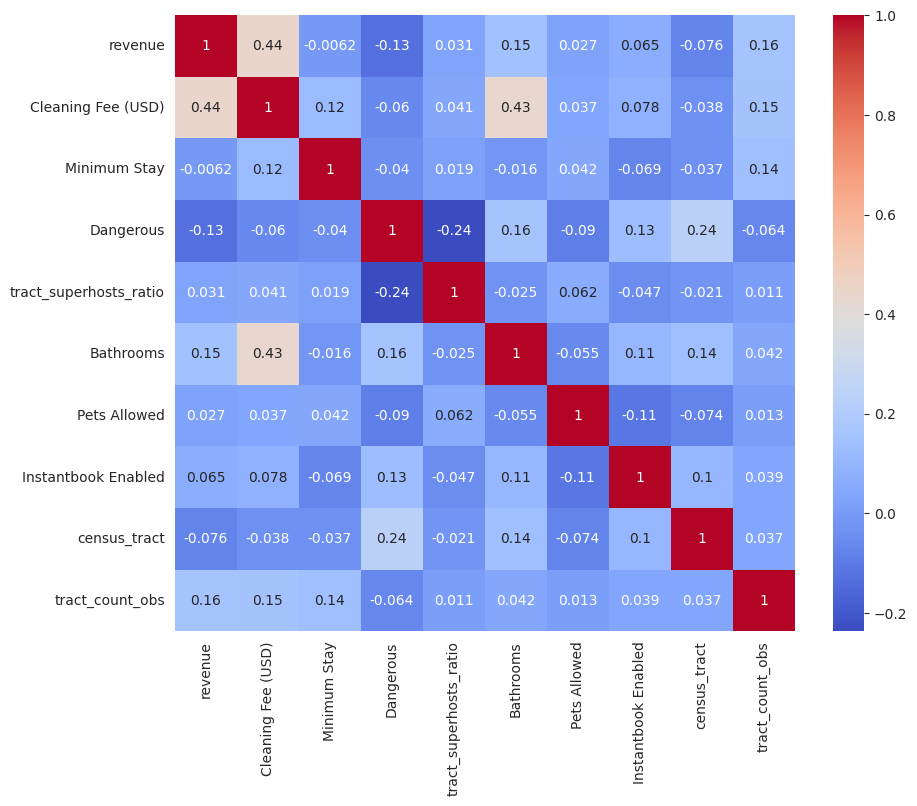

In [ ]:
# Q2- DID model with more variables
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import numpy as np
df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# Split the data into training and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = train_df[train_df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 8 and 9
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 8 and 9
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [8, 9]))

# Now, filtered_df contains only the hosts that have data for both periods 8 and 9

# Convert 'superhost_period_all' to a dummy variable
filtered_df['after'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 9 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

filtered_df['log_revenue'] = np.log(filtered_df['revenue'])
filtered_df['log_revenue_period_tract'] = np.log(filtered_df['revenue_period_tract'])
filtered_df['log_tract_count_obs'] = np.log(filtered_df['tract_count_obs'])
filtered_df['log_tract_total_pop'] = np.log(filtered_df['tract_total_pop'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + after + superhost_change_gain_superhost:after + prev_year_superhosts + ' \
'Bedrooms + Bathrooms + C(Q("Listing Type")) + Q("Cleaning Fee (USD)") + Q("Minimum Stay") + Q("Pets Allowed") + Q("Number of Photos") + Q("Instantbook Enabled") + Dangerous + C(census_tract) + '\
'Q("prev_Number of Reviews")+ Q("prev_Rating Overall")  + num_5_star_Rev_pastYear + booked_days + prev_available_days_aveListedPrice  + Q("prev_Nightly Rate") +' \
'log_tract_total_pop + log_revenue_period_tract + booked_days_period_tract + tract_count_obs + tract_superhosts_ratio + tract_price_variance +Q("Nightly Rate_tractQuartile")'
 #
       #   \'+ zip_black_nothispanic_percent + zip_asian_nothispanic_percent')


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())



# Selecting relevant columns for correlation analysis
# Include your target variable 'revenue' and other variables of interest
selected_columns = ['revenue', 'Cleaning Fee (USD)', 'Listing Type',
                    'Minimum Stay', 'Dangerous', 'tract_superhosts_ratio', 'Bathrooms',
                    'Pets Allowed', 'Instantbook Enabled', 'census_tract','tract_count_obs']

# Creating a smaller DataFrame with the selected columns
correlation_df = filtered_df[selected_columns]

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Display the correlation matrix
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

                        Superhost  Cleaning Fee (USD)  Rating Overall  \
Superhost                1.000000           -0.016075        0.120506   
Cleaning Fee (USD)      -0.016075            1.000000        0.015069   
Rating Overall           0.120506            0.015069        1.000000   
Minimum Stay             0.027959            0.117744        0.019973   
Dangerous               -0.036952           -0.060432       -0.032404   
tract_superhosts_ratio   0.295540            0.040651        0.057675   
Bathrooms               -0.044095            0.433335       -0.001300   
Pets Allowed             0.025279            0.036725        0.001977   
Instantbook Enabled     -0.049834            0.078315       -0.054686   
census_tract            -0.009670           -0.038437       -0.022329   
prev_Rating Overall      0.123024            0.010645        0.889882   

                        Minimum Stay  Dangerous  tract_superhosts_ratio  \
Superhost                   0.027959  -0.036952 

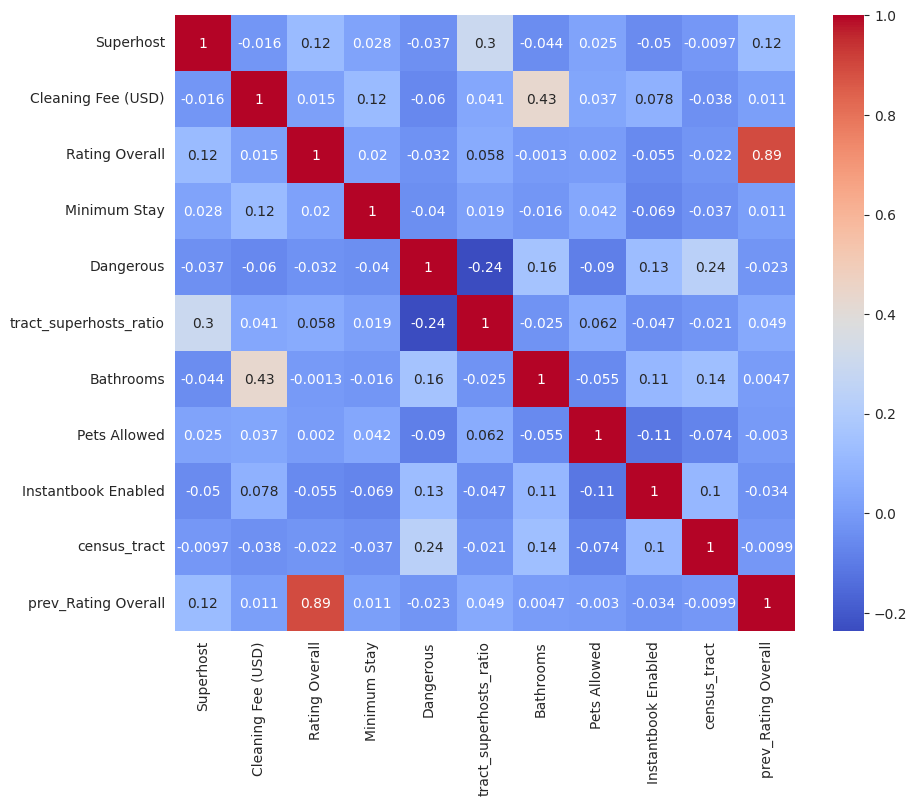

In [ ]:
#Selecting relevant columns for correlation analysis
# Include your target variable 'revenue' and other variables of interest
selected_columns = ['Superhost', 'Cleaning Fee (USD)', 'Rating Overall',
                    'Minimum Stay', 'Dangerous', 'tract_superhosts_ratio', 'Bathrooms',
                    'Pets Allowed', 'Instantbook Enabled', 'census_tract','prev_Rating Overall']

# Creating a smaller DataFrame with the selected columns
correlation_df = filtered_df[selected_columns]

# Calculating the correlation matrix
correlation_matrix = correlation_df.corr()

# Display the correlation matrix
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Q2- DID Comparison Group without booked_days
# Period 7 ~ 8
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# Split the data into training and validation sets (80% train, 20% validation)
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 7 and 8
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 7 and 8
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [7, 8]))

# Now, filtered_df contains only the hosts that have data for both periods 7 and 8

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 8 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed")  + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     352.0
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:23:06   Log-Likelihood:            -1.2217e+05
No. Observations:               12690   AIC:                         2.444e+05
Df Residuals:                   12655   BIC:                         2.447e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

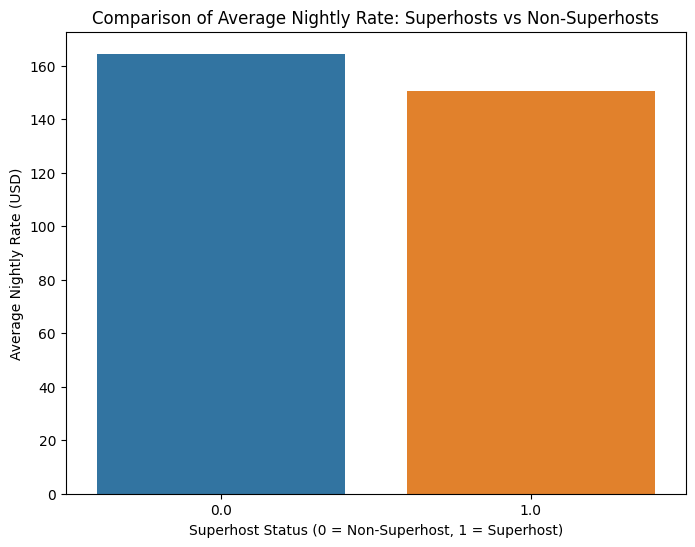

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Group the data by 'Superhost' and calculate the mean 'Nightly Rate' for each group
grouped_data = df.groupby('Superhost')['Nightly Rate'].mean().reset_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Superhost', y='Nightly Rate', data=grouped_data)

# Adding titles and labels
plt.title('Comparison of Average Nightly Rate: Superhosts vs Non-Superhosts')
plt.xlabel('Superhost Status (0 = Non-Superhost, 1 = Superhost)')
plt.ylabel('Average Nightly Rate (USD)')

# Show the plot
plt.show()

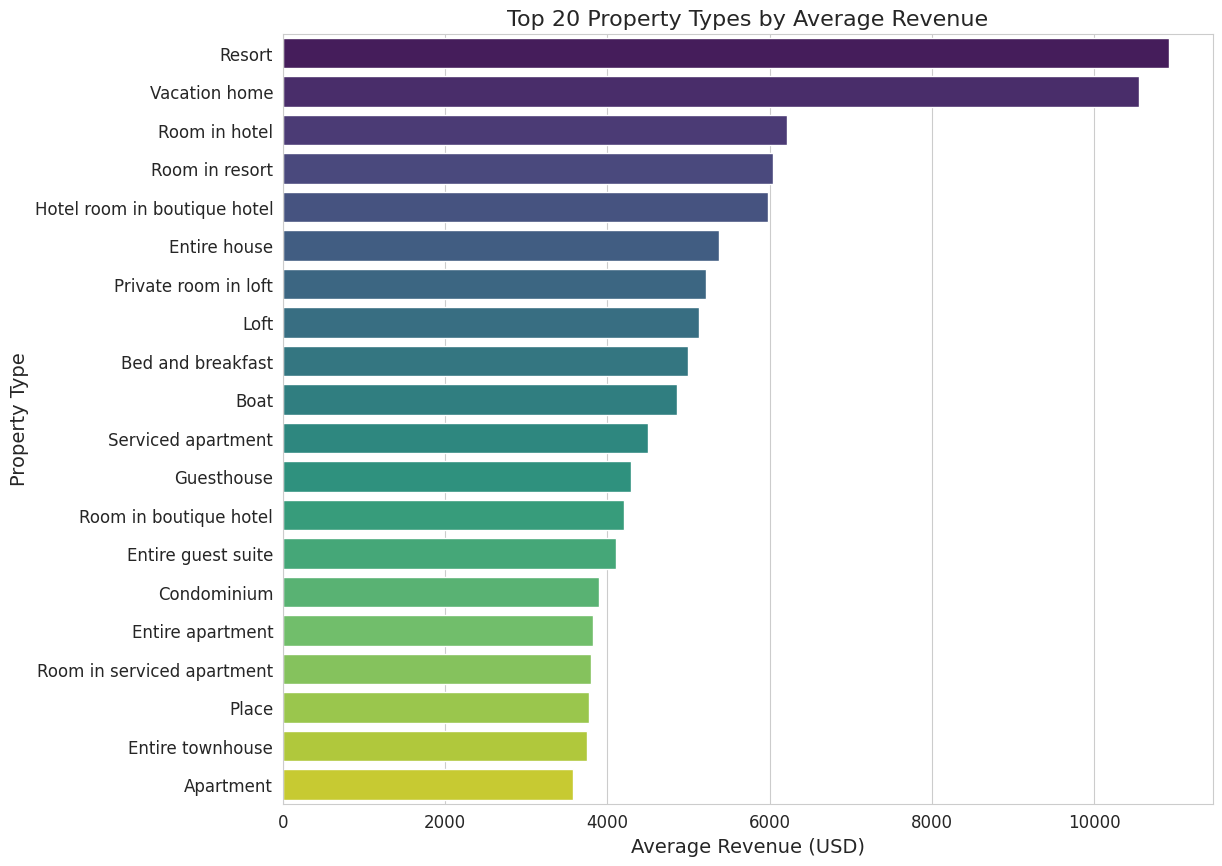

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Filter the DataFrame to include only periods 8 to 15
df_filtered = df[df['superhost_period_all'].between(8, 15)]

# Drop rows where 'revenue' is missing in the filtered dataset
df_filtered = df_filtered.dropna(subset=['revenue'])

# Group the data by 'Property Type' and calculate the mean revenue for each type
grouped_data = df_filtered.groupby('Property Type')['revenue'].mean().reset_index()

# Sort the data by revenue and select the top 20 property types
grouped_data = grouped_data.sort_values('revenue', ascending=False).head(20)

# Plotting the bar chart
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.barplot(x='revenue', y='Property Type', data=grouped_data, palette='viridis')

# Customizing the plot
plt.title('Top 20 Property Types by Average Revenue', fontsize=16)
plt.xlabel('Average Revenue (USD)', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

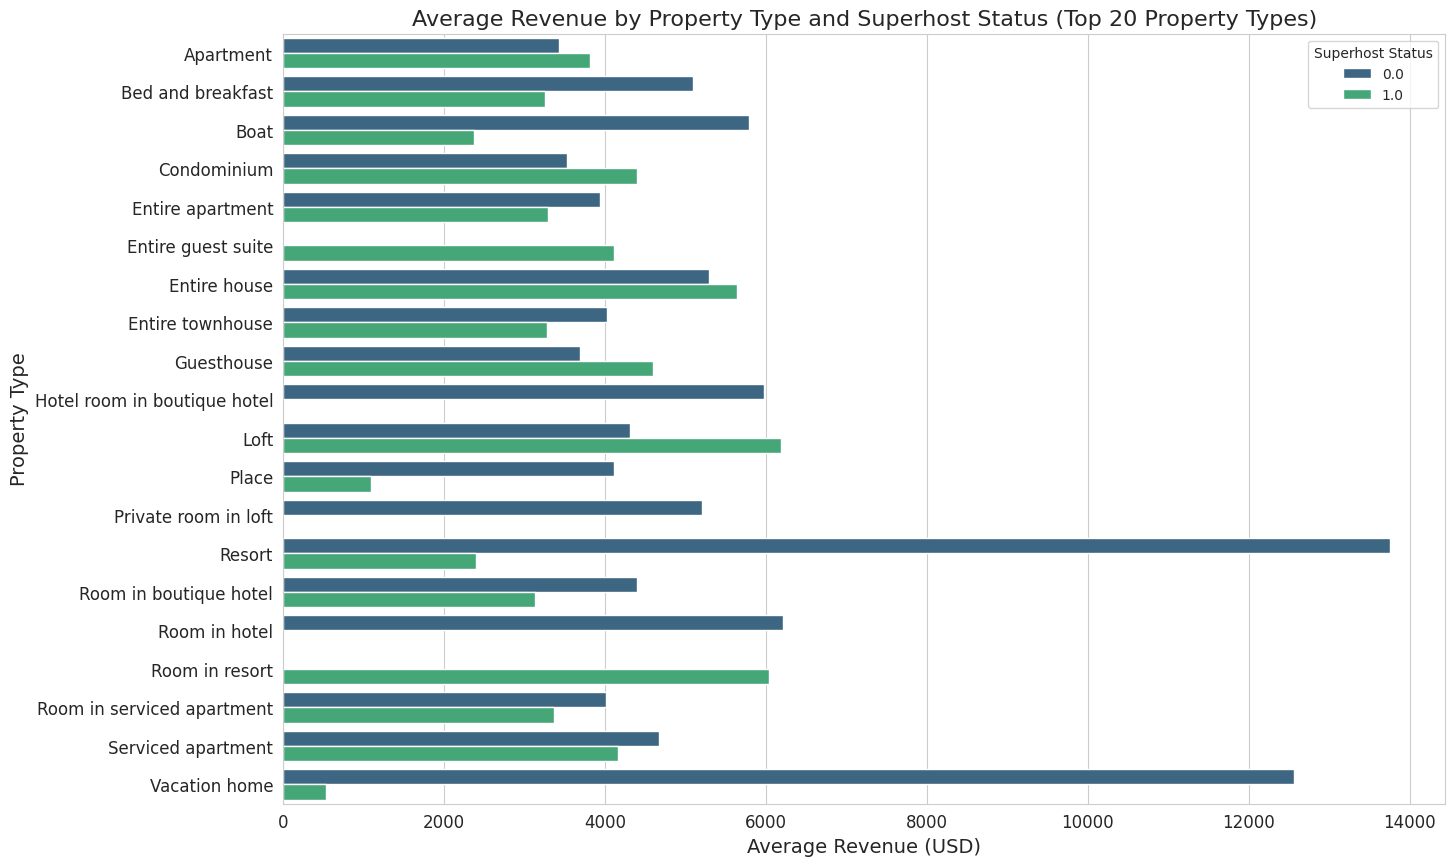

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Filter the DataFrame to include only periods 8 to 15
df_filtered = df[df['superhost_period_all'].between(8, 15)]

# Drop rows where 'revenue' is missing in the filtered dataset
df_filtered = df_filtered.dropna(subset=['revenue'])

# Identify the top 20 property types based on average revenue
top_20_property_types = df_filtered.groupby('Property Type')['revenue'].mean().nlargest(20).index

# Filter the dataset to include only the top 20 property types
df_top_20 = df_filtered[df_filtered['Property Type'].isin(top_20_property_types)]

# Group the data by 'Property Type' and 'Superhost', then calculate the mean revenue
grouped_data = df_top_20.groupby(['Property Type', 'Superhost'])['revenue'].mean().reset_index()

# Plotting the grouped bar chart
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.barplot(x='revenue', y='Property Type', hue='Superhost', data=grouped_data, palette='viridis')

# Customizing the plot
plt.title('Average Revenue by Property Type and Superhost Status (Top 20 Property Types)', fontsize=16)
plt.xlabel('Average Revenue (USD)', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Superhost Status')

# Show the plot
plt.show()

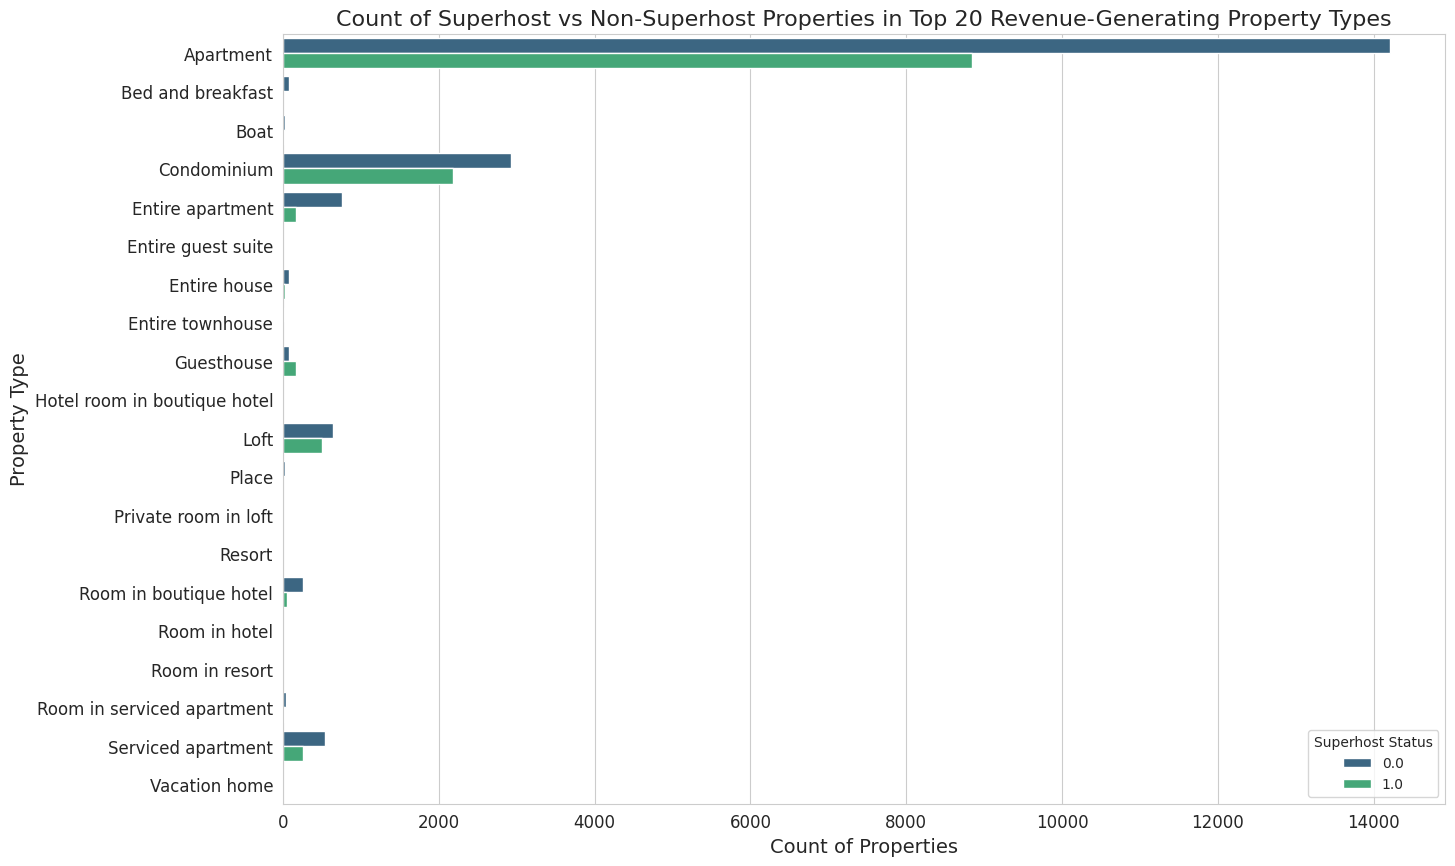

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Filter the DataFrame to include only periods 8 to 15
df_filtered = df[df['superhost_period_all'].between(8, 15)]

# Drop rows where 'revenue' is missing in the filtered dataset
df_filtered = df_filtered.dropna(subset=['revenue'])

# Identify the top 20 property types based on average revenue
top_20_property_types = df_filtered.groupby('Property Type')['revenue'].mean().nlargest(20).index

# Filter the dataset to include only the top 20 property types
df_top_20 = df_filtered[df_filtered['Property Type'].isin(top_20_property_types)]

# Group the data by 'Property Type' and 'Superhost', then count the number of listings
count_data = df_top_20.groupby(['Property Type', 'Superhost']).size().reset_index(name='count')

# Plotting the grouped bar chart
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.barplot(x='count', y='Property Type', hue='Superhost', data=count_data, palette='viridis')

# Customizing the plot
plt.title('Count of Superhost vs Non-Superhost Properties in Top 20 Revenue-Generating Property Types', fontsize=16)
plt.xlabel('Count of Properties', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Superhost Status')

# Show the plot
plt.show()

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Define the period ranges
period_ranges = {
    'Period 5-12': range(5, 13),
    'Period 8-15': range(8, 16),
    'Period 10-17': range(10, 18),
    'Period 13-20': range(13, 21)
}

# Initialize a dictionary to store the counts of missing values
missing_values_counts = {}

# Loop through each period range and count missing values
for period_name, periods in period_ranges.items():
    # Filter the DataFrame for the current period range
    filtered_df = df[df['superhost_period_all'].isin(periods)]

    # Count the missing values in the 'revenue' column
    missing_count = filtered_df['revenue'].isna().sum()

    # Store the count in the dictionary
    missing_values_counts[period_name] = missing_count

# Display the results
for period, count in missing_values_counts.items():
    print(f"Missing 'revenue' values in {period}: {count}")

Missing 'revenue' values in Period 5-12: 17800
Missing 'revenue' values in Period 8-15: 15661
Missing 'revenue' values in Period 10-17: 17381
Missing 'revenue' values in Period 13-20: 20308


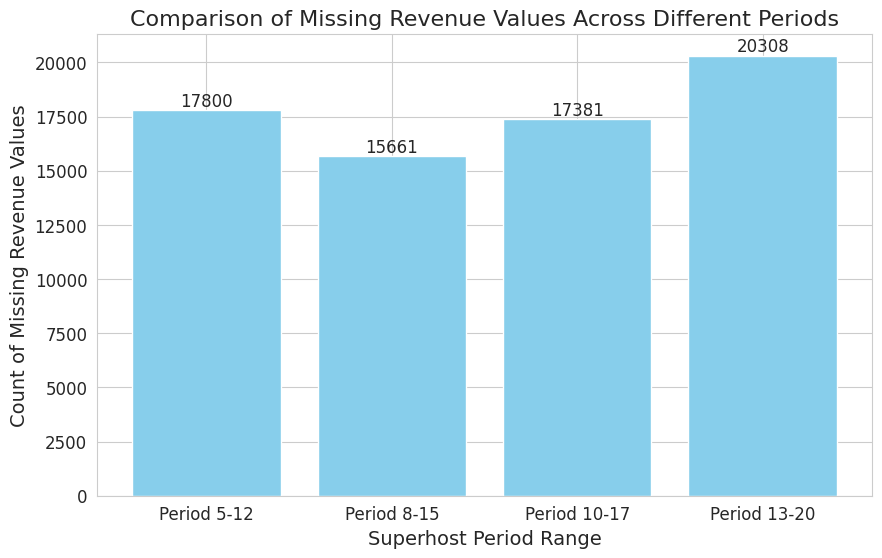

In [ ]:
# Compare the difference in missing value across different evaluation periods
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Define the period ranges
period_ranges = {
    'Period 5-12': range(5, 13),
    'Period 8-15': range(8, 16),
    'Period 10-17': range(10, 18),
    'Period 13-20': range(13, 21)
}

# Initialize a dictionary to store the counts of missing values
missing_values_counts = {}

# Loop through each period range and count missing values
for period_name, periods in period_ranges.items():
    # Filter the DataFrame for the current period range
    filtered_df = df[df['superhost_period_all'].isin(periods)]

    # Count the missing values in the 'revenue' column
    missing_count = filtered_df['revenue'].isna().sum()

    # Store the count in the dictionary
    missing_values_counts[period_name] = missing_count

# Prepare data for plotting
periods = list(missing_values_counts.keys())
missing_counts = list(missing_values_counts.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(periods, missing_counts, color='skyblue')

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12)

# Customizing the plot
plt.title('Comparison of Missing Revenue Values Across Different Periods', fontsize=16)
plt.xlabel('Superhost Period Range', fontsize=14)
plt.ylabel('Count of Missing Revenue Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

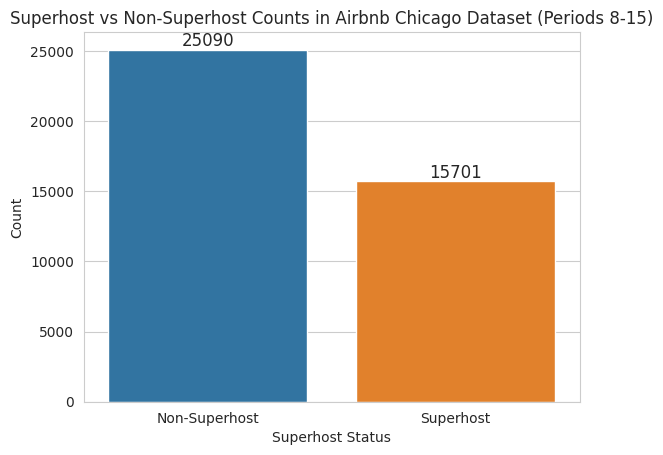

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Filter the DataFrame to include only periods 8 to 15
df_filtered = df[df['superhost_period_all'].between(8, 15)]

# Drop rows where 'revenue' is missing in the filtered dataset
df_filtered = df_filtered.dropna(subset=['revenue'])

# Count the occurrences of each category in the filtered data
superhost_counts_filtered = df_filtered['Superhost'].value_counts()

# Create a bar plot for the filtered data
bars = sns.barplot(x=superhost_counts_filtered.index, y=superhost_counts_filtered.values)
plt.xlabel('Superhost Status')
plt.ylabel('Count')
plt.title('Superhost vs Non-Superhost Counts in Airbnb Chicago Dataset (Periods 8-15)')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])  # Rename x-ticks for clarity

# Adding the count above each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

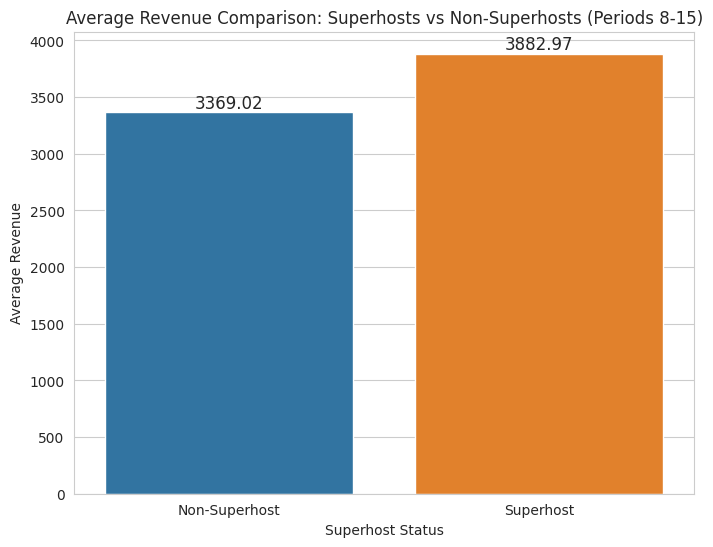

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('airbnb_Chicago.csv')

# Filter the DataFrame to include only periods 8 to 15
df_filtered = df[df['superhost_period_all'].between(8, 15)]

# Drop rows where 'revenue' is missing in the filtered dataset
df_filtered = df_filtered.dropna(subset=['revenue'])

# Group by 'Superhost' status and calculate the average revenue
average_revenue = df_filtered.groupby('Superhost')['revenue'].mean().reset_index()

# Create a bar plot for the average revenue
plt.figure(figsize=(8, 6))
sns.barplot(x='Superhost', y='revenue', data=average_revenue)
plt.xlabel('Superhost Status')
plt.ylabel('Average Revenue')
plt.title('Average Revenue Comparison: Superhosts vs Non-Superhosts (Periods 8-15)')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])  # Rename x-ticks for clarity

# Adding the average revenue above each bar
for bar in plt.gca().patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
             ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

In [ ]:
####################################################################################################################################################################################################

In [ ]:
# Period 8 ~ 9
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 8 and 9
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 8 and 9
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [8, 9]))

# Now, filtered_df contains only the hosts that have data for both periods 8 and 9

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 9 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed") + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     879.7
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:52:57   Log-Likelihood:            -1.2058e+05
No. Observations:               13223   AIC:                         2.412e+05
Df Residuals:                   13187   BIC:                         2.415e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# Period 9 ~ 10
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 9 and 10
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 9 and 10
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [9, 10]))

# Now, filtered_df contains only the hosts that have data for both periods 9 and 10

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 10 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed") + Q("Nightly Rate") + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     848.0
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:40:14   Log-Likelihood:            -1.2222e+05
No. Observations:               13362   AIC:                         2.445e+05
Df Residuals:                   13325   BIC:                         2.448e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# Period 10 ~ 11
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 10 and 11
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 10 and 11
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [10, 11]))

# Now, filtered_df contains only the hosts that have data for both periods 10 and 11

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 11 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed") + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     872.6
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:13:35   Log-Likelihood:            -1.2644e+05
No. Observations:               13747   AIC:                         2.530e+05
Df Residuals:                   13711   BIC:                         2.532e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# Period 11 ~ 12
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 11 and 12
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 11 and 12
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [11, 12]))

# Now, filtered_df contains only the hosts that have data for both periods 11 and 12

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 12 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed") + Q("Nightly Rate") + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     876.3
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:14:42   Log-Likelihood:            -1.2925e+05
No. Observations:               13795   AIC:                         2.586e+05
Df Residuals:                   13758   BIC:                         2.589e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# Period 19 ~ 20
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv('airbnb_Chicago.csv')

# List of dangerous neighborhoods
dangerous_neighborhoods = ['Washington Park', 'West Garfield Park', 'Englewood', 'North Lawndale', 'East Garfield Park', 'West Englewood', 'Austin', 'Grand Crossing', 'Riverdale', 'South Shore']

# Create a new column 'Dangerous' and set values to 1 for specified neighborhoods, else 0
df['Dangerous'] = df['Neighborhood'].isin(dangerous_neighborhoods).astype(int)

# filters dataset to include only those hosts who were not Superhosts in the previous period
subset_df = df[df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 19 and 20
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 19 and 20
filtered_df = subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [19, 20]))

# Now, filtered_df contains only the hosts that have data for both periods 19 and 20

# Convert 'superhost_period_all' to a dummy variable
filtered_df['period_dummy'] = filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 20 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

# Define the formula for the DiD model
formula = 'revenue ~ superhost_change_gain_superhost + period_dummy + superhost_change_gain_superhost:period_dummy + rating_ave_pastYear + numReviews_pastYear + ' \
          'numCancel_pastYear + num_5_star_Rev_pastYear + prev_numReviews_pastYear + prev_numCancel_pastYear + prev_prop_5_StarReviews_pastYear + numReservedDays_pastYear + ' \
          'prev_numReservedDays_pastYear + available_days + available_days_aveListedPrice + Q("Minimum Stay") + Q("Pets Allowed") + Q("Nightly Rate") + Q("prev_Nightly Rate")  + '\
          'prev_host_is_superhost1 + revenue_period_city + booked_days_period_tract + Q("Rating Overall") + booked_days + booked_days_avePrice + prev_available_days_aveListedPrice + '\
          'Q("Max Guests") + Q("Cleaning Fee (USD)") + Q("Number of Photos") + Q("Instantbook Enabled") + Q("Number of Reviews") + Q("Rating Overall") + Dangerous + ' \
          'tract_total_pop + zip_hispanic_or_latino_anyrace_percent + zip_white_nothispanic_percent + zip_black_nothispanic_percent + zip_asian_nothispanic_percent'


# Fit the model
model = smf.ols(formula, data=filtered_df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     759.3
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:43:06   Log-Likelihood:            -1.0665e+05
No. Observations:               11323   AIC:                         2.134e+05
Df Residuals:                   11286   BIC:                         2.136e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# filters dataset to include only those hosts who were not Superhosts in the previous period
val_subset_df = val_df[val_df['prev_host_is_superhost'] == 0]

# Ensure Data Availability for Both Periods 7 and 8
# Group by 'Airbnb Host ID' and filter out those that don't have both periods 7 and 8
val_filtered_df = val_subset_df.groupby('Airbnb Host ID').filter(lambda x: all(period in x['superhost_period_all'].values for period in [7, 8]))

# Now, val_filtered_df contains only the hosts that have data for both periods 7 and 8

# Convert 'superhost_period_all' to a dummy variable
val_filtered_df['period_dummy'] = val_filtered_df['superhost_period_all'].apply(lambda x: 1 if x == 8 else 0)

# Drop rows where 'revenue' is missing in the filtered dataset
filtered_df = filtered_df.dropna(subset=['revenue'])

val_filtered_df['superhost_change_gain_superhost:period_dummy'] = val_filtered_df['superhost_change_gain_superhost'] * val_filtered_df['period_dummy']
# List of columns used in your model
model_columns = ['superhost_change_gain_superhost', 'period_dummy', 'superhost_change_gain_superhost:period_dummy', 'rating_ave_pastYear', 'numReviews_pastYear', 'numCancel_pastYear', 'num_5_star_Rev_pastYear',
                 'prev_numReviews_pastYear', 'prev_numCancel_pastYear', 'prev_prop_5_StarReviews_pastYear', 'numReservedDays_pastYear', 'prev_numReservedDays_pastYear', 'available_days','available_days_aveListedPrice',
                 'Minimum Stay', 'Pets Allowed', 'Nightly Rate', 'prev_Nightly Rate', 'tract_total_pop', 'prev_host_is_superhost1', 'revenue_period_city', 'booked_days_period_tract',
                 'Rating Overall', 'booked_days', 'booked_days_avePrice', 'prev_available_days_aveListedPrice', 'Max Guests', 'Cleaning Fee (USD)', 'Number of Photos', 'Instantbook Enabled',
                 'Number of Reviews', 'Rating Overall', 'Dangerous', 'tract_total_pop', 'zip_hispanic_or_latino_anyrace_percent', 'zip_white_nothispanic_percent', 'zip_black_nothispanic_percent',
                 'zip_asian_nothispanic_percent']

# Keep only the columns used in the model
val_filtered_df = val_filtered_df[model_columns]

# Now make predictions
val_filtered_df['predicted_revenue'] = model.predict(val_filtered_df)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mae = mean_absolute_error(val_filtered_df['revenue'], val_filtered_df['predicted_revenue'])
mse = mean_squared_error(val_filtered_df['revenue'], val_filtered_df['predicted_revenue'])
r2 = r2_score(val_filtered_df['revenue'], val_filtered_df['predicted_revenue'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")
print(val_filtered_df.isna().sum())

PatsyError: ignored

In [ ]:
##### Define the Backward Selection Function
import re

def fit_and_remove_a_variable(vars, data):
    model_fun = smf.ols(formula=f"revenue ~ {' + '.join(vars)}", data=data).fit()
    p_values = model_fun.pvalues.drop('Intercept')
    max_p_var = re.sub('\[.*?\]', '', p_values.idxmax())
    while max_p_var not in vars:
        p_values = p_values.drop(p_values.idxmax())
        max_p_var = re.sub('\[.*?\]', '', p_values.idxmax())
    vars.remove(max_p_var)
    print(f"Removed: {max_p_var}")
    return model_fun, vars

# Extract Variables from the Initial Formula
initial_vars = formula.split('~')[1].split('+')
initial_vars = [var.strip() for var in initial_vars]  # Clean up any leading/trailing whitespace

# Perform Backward Selection
significance_level = 0.05  # Set your significance level

while True:
    model, initial_vars = fit_and_remove_a_variable(initial_vars, filtered_df)
    max_p_value = max(model.pvalues.drop('Intercept'))
    if max_p_value < significance_level:
        break
# Fit the Final Model with the Selected Variables
final_formula = 'revenue ~ ' + ' + '.join(initial_vars)
final_model = smf.ols(final_formula, data=filtered_df).fit()
print(final_model.summary())





Removed: zip_asian_nothispanic_percent
Removed: C(Q("Property Type"))
Removed: prev_numReviews_pastYear
Removed: booked_days_period_tract
Removed: revenue_period_city
Removed: prev_host_is_superhost1
Removed: Q("Rating Overall")
Removed: Q("Rating Overall")
Removed: Q("Max Guests")
Removed: numCancel_pastYear
Removed: period_dummy
Removed: superhost_change_gain_superhost
Removed: Dangerous
Removed: prev_numCancel_pastYear
Removed: Q("Minimum Stay")
Removed: prev_prop_5_StarReviews_pastYear
Removed: prev_available_days_aveListedPrice
Removed: available_days_aveListedPrice
Removed: Q("Number of Photos")
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     967.1
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0

PatsyError: ignored